$$
\frac{d W}{d p} = (p^2 + Q)\left[ p Q + p^2 U + Q U \right] + \left( \frac{2 p}{p^2 + Q} - \frac{1}{p} \right) W - \frac{W^2}{p} 
$$

$$
W(\infty) = -\frac{1}{2} U^{1/2} p^{5/2} - \frac{7}{4} 
$$

In [1]:
using Plots, DifferentialEquations, LaTeXStrings, Printf, SpecialFunctions

# Define the ODE function with parameters
f(w, p, t) = ((2t)/(t^2+p[1]) - (1/t))*w - (w^2/t) + (t^2 + p[1])*(t*p[1] + t^2*p[2] + p[1]*p[2])

# Q value -- value to use when Q fixed (plotting)
Q = 10^(-2)
Q_display = round(Q, digits=2)
Q_values = 10.0 .^ range(-4, -0.02, length=100)

# U value -- value to use when U fixed (plotting)
U = 10^(-2) 
U_display = round(U, digits=2)
U_values = 10.0 .^ range(-4, -0.02, length=100)

# Arrays to store results
logU_values = log10.(U_values)
logQ_values = log10.(Q_values)
logDelta_valuesQ = similar(Q_values)  # For varying Q with fixed U
logDelta_valuesU = similar(U_values)  # For varying U with fixed Q

# Time span (integrating backward in "time" t)
tspan = (20.0, 1e-7)  # Avoid t=0 to prevent division by zero

# threshold value on Δ so there's no asymptote from above when plotted
threshold = 1.0

# Function to solve the ODE and compute logDelta
function solve_and_compute_logΔ(p1, p2)
    # Initial condition
    w0 = -(0.5)*sqrt(p2)*tspan[1]^(5/2) - (7/4)
    
    # Create the ODE problem with parameters
    prob = ODEProblem(f, w0, tspan, [p1, p2])
    
    try
        # Solve with a stiff solver (Rodas5 is good for stiff problems)
        sol = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)
        
        # Compute W'(t) at the smallest t in the solution (near t=0)
        t_min = minimum(sol.t)  # Closest point to t=0 (e.g., t=1e-6)
        W_prime_near_0 = sol(t_min, Val{1})  # First derivative at t_min
        
        # Extrapolate W'(0) ≈ W'(t_min) + O(t_min) (assumes W' is finite at t=0)
        W_prime_0 = W_prime_near_0  # Or refine with fitting if needed
        
        # Compute π / W'(0)
        Δhat = π / W_prime_0
        
        return log10(abs(Δhat))
    catch e
        @warn "Failed for parameters p1=$p1, p2=$p2: $e"
        return NaN
    end
end

# Case 1: Vary U with fixed Q
for (i, U) in enumerate(U_values)
    logDelta_valuesU[i] = solve_and_compute_logΔ(Q, U)
end

# Case 2: Vary Q with fixed U
for (i, Q) in enumerate(Q_values)
    logDelta_valuesQ[i] = solve_and_compute_logΔ(Q, U)
end

In [2]:
using Base.MathConstants

In [3]:
sm_cf_U = [log10(abs( ( 2*pi*gamma(3/4)*Q^(5/4) ) / ( gamma(1/4) ) )) for U in U_values];
sm_coppi_U = [log10(abs( ( -pi*gamma(Q^(3/2)/4 - 1/4)*Q^(5/4) ) / ( 8*gamma(Q^(3/2)/4 + 5/4) ) )) for U in U_values];
tf_cf_U = [log10(abs( ( 5^(3/5)*pi*gamma(4/5)*U^(1/5)*Q ) / ( gamma(1/5) ) )) for U in U_values];

# tf_ncf_U = [-log10(abs( pi / (U*Q^2*(1 - 2*γ + log(4))) )) for U in U_values];

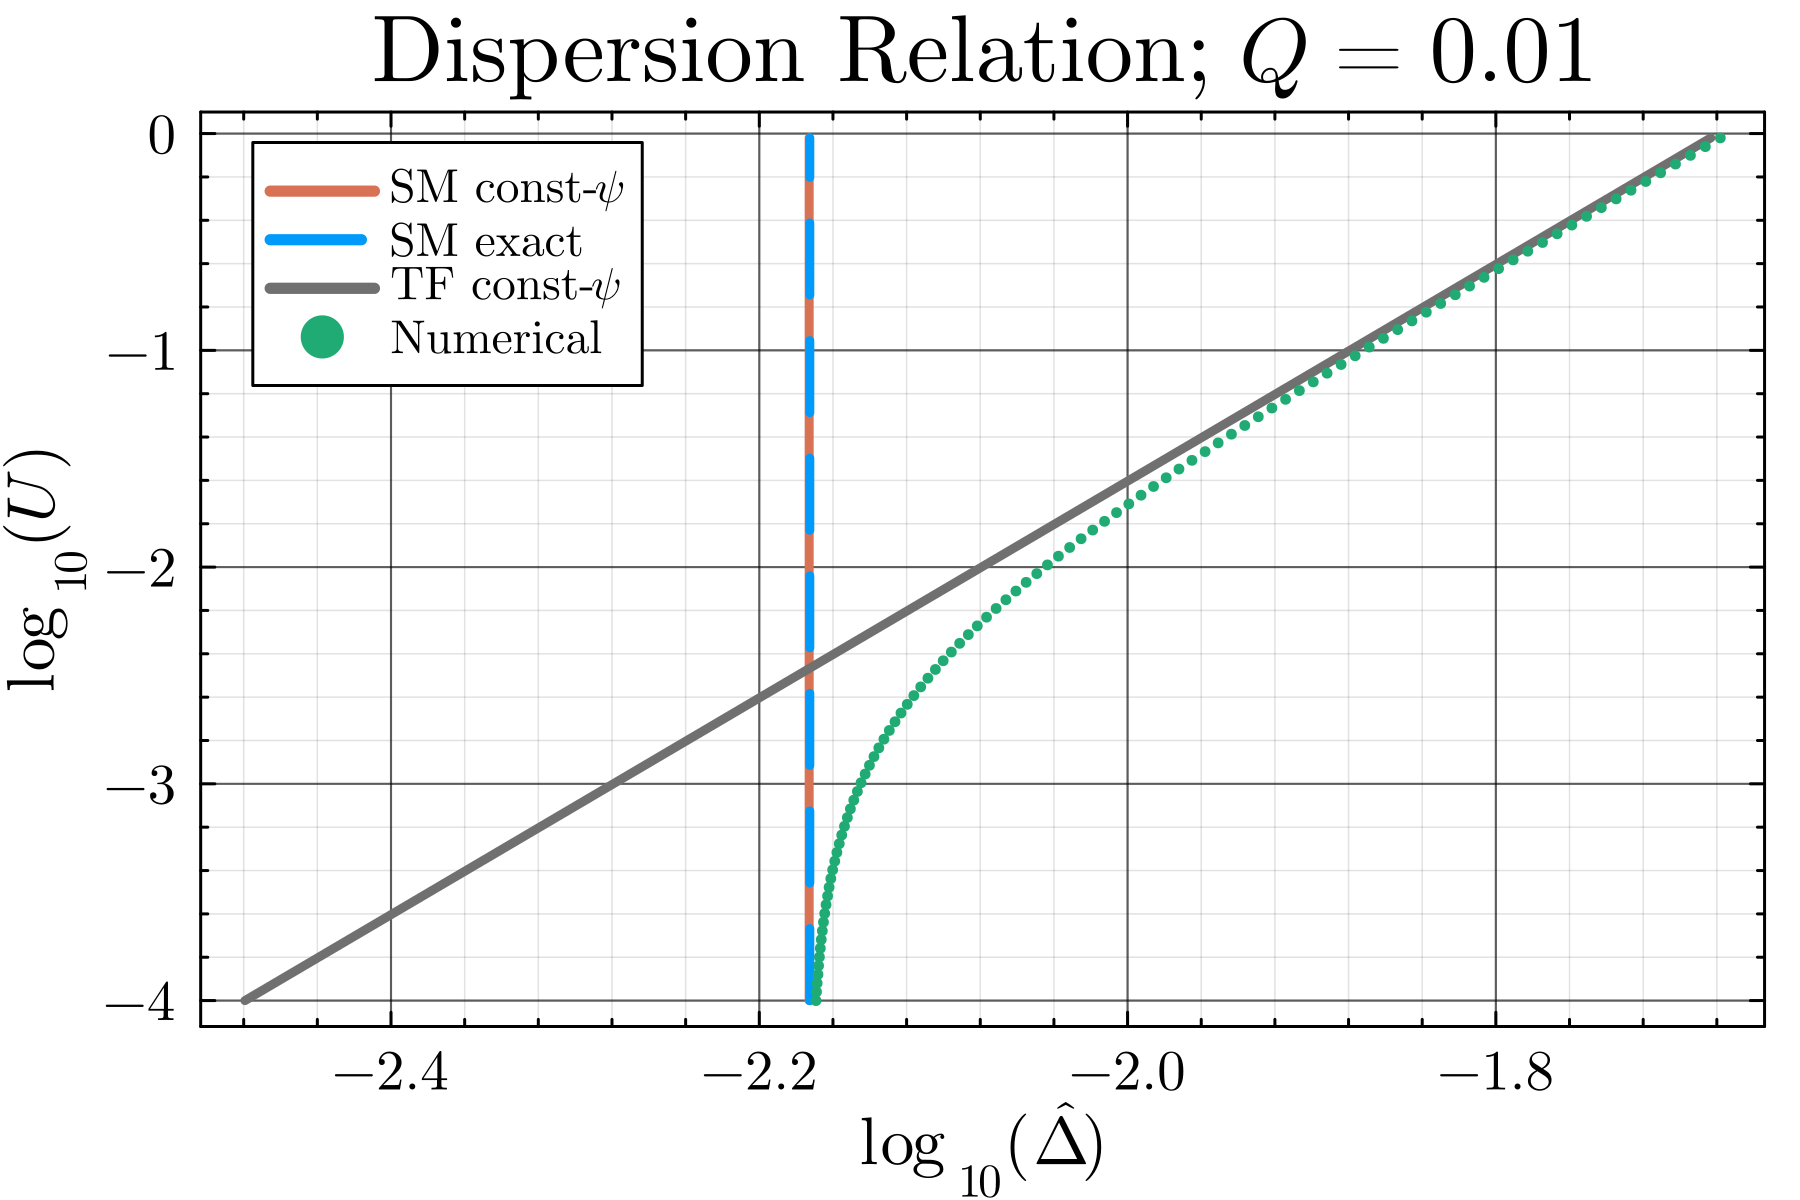

In [4]:
# Create the plot
theme(:dao)
plot(sm_cf_U, logU_values, label=L"SM const-$\psi$", linewidth=3, markersize=2)
plot!(sm_coppi_U, logU_values, label="SM exact", linewidth=3, markersize=2, linestyle=:dash)
plot!(tf_cf_U, logU_values, label=L"TF const-$\psi$", linewidth=3, markersize=2)
# plot!(tf_ncf_U, logU_values, label=L"TF nonconst-$\psi$", linewidth=3, markersize=2)
scatter!(logDelta_valuesU, logU_values, label="Numerical", linewidth=3, markersize=2, linestyle=:dash,
    title=L"Dispersion Relation; $Q=$%$Q_display",
    xlabel=L"\log_{10}(\hat{\Delta})",
    ylabel=L"\log_{10}(U)",
    legend = :best,
    titlefontsize=20,
    tickfontsize=12,
    legendfontsize=10,
    yguidefontsize=15,
    xguidefontsize=15,
    dpi=300,
    )
# savefig("tf_dispersionU.png")

In [5]:
sm_cf_Q = [log10(abs( ( 2*pi*gamma(3/4)*Q^(5/4) ) / ( gamma(1/4) ) )) for Q in Q_values];
sm_coppi_Q = [log10(abs( ( -pi*gamma(Q^(3/2)/4 - 1/4)*Q^(5/4) ) / ( 8*gamma(Q^(3/2)/4 + 5/4) ) )) for Q in Q_values];
tf_cf_Q = [log10(abs( ( 5^(3/5)*pi*gamma(4/5)*U^(1/5)*Q ) / ( gamma(1/5) ) )) for Q in Q_values];

# sm_ncf_Q = [log10(abs( pi*Q )) for Q in Q_values];

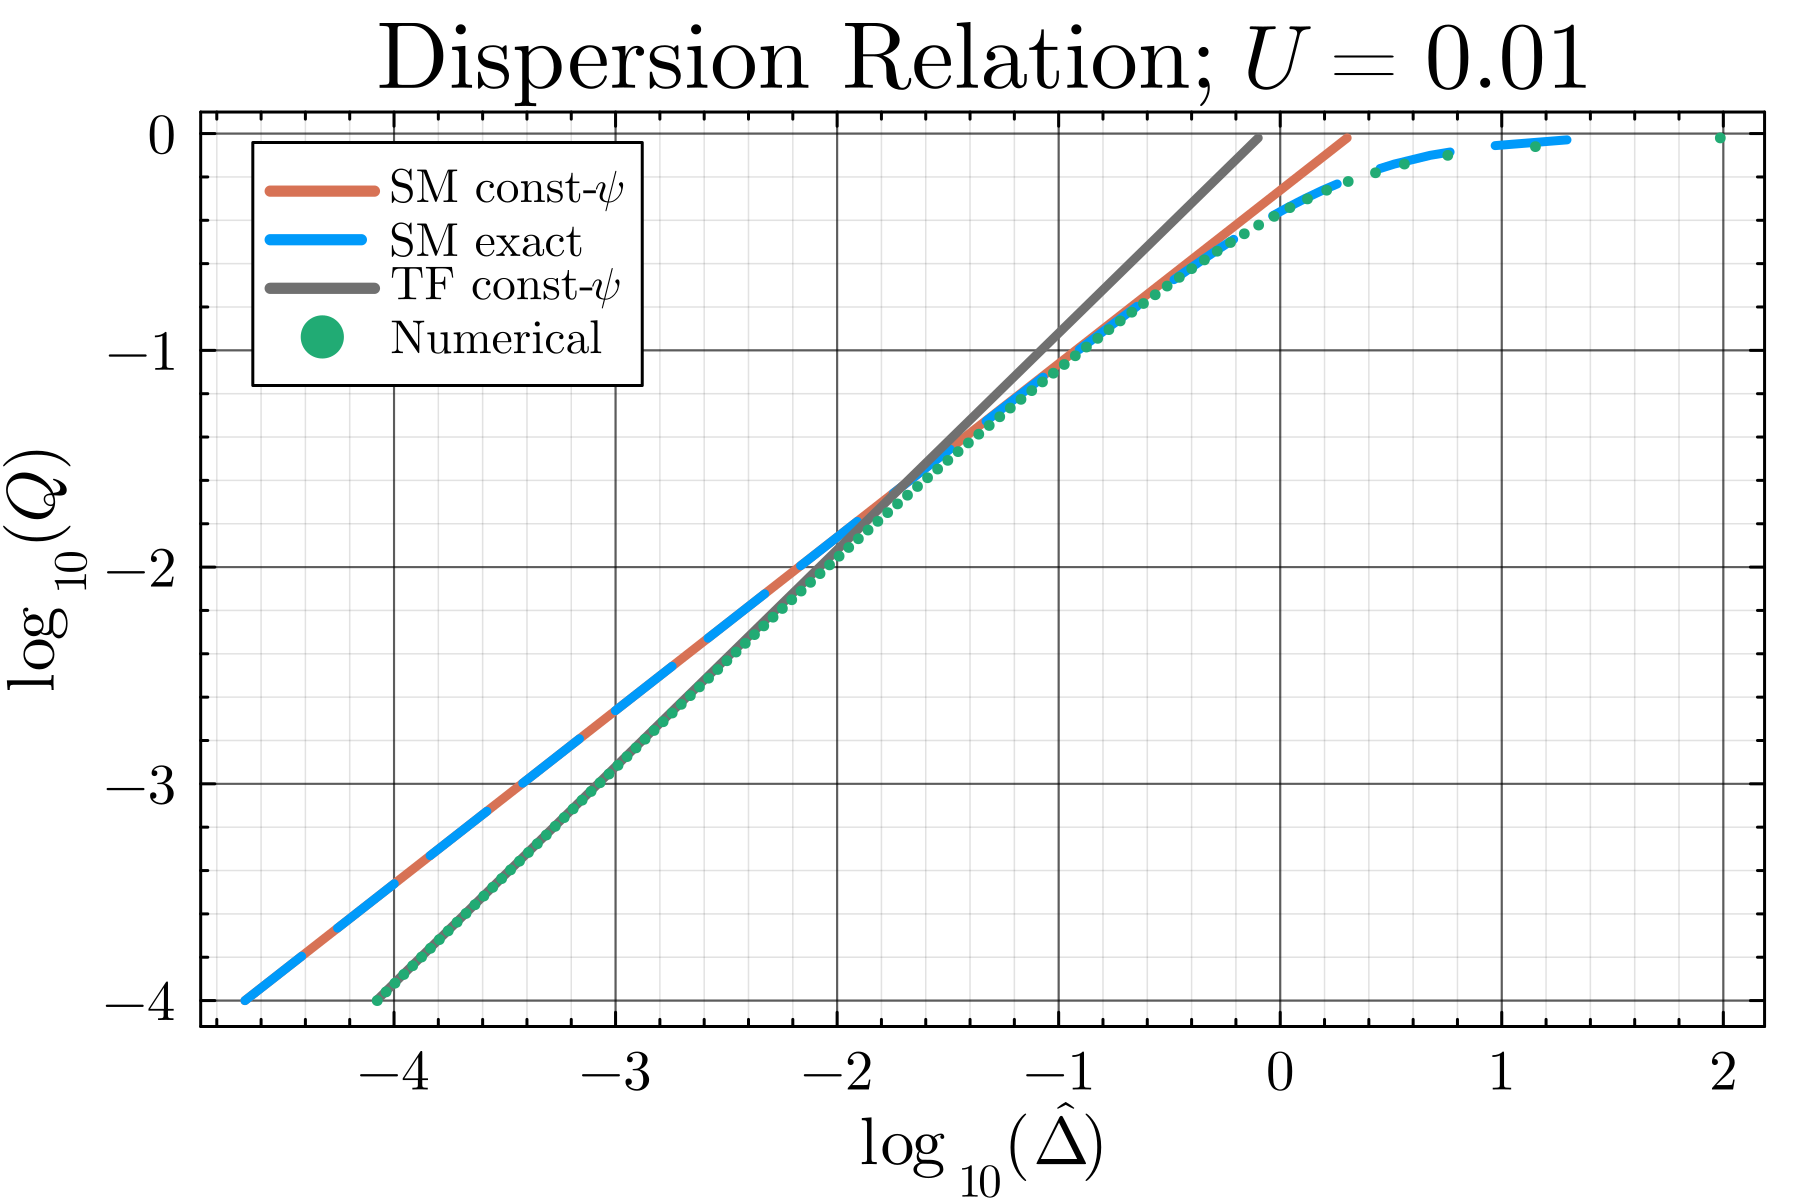

In [6]:
# Create the plot
plot(sm_cf_Q, logQ_values, label=L"SM const-$\psi$", linewidth=3, markersize=2)
plot!(sm_coppi_Q, logQ_values, label="SM exact", linewidth=3, markersize=2, linestyle=:dash)
plot!(tf_cf_Q, logQ_values, label=L"TF const-$\psi$", linewidth=3, markersize=2)
# plot!(sm_ncf_Q, logQ_values, label=L"SM nonconst-$\psi$", linewidth=3, markersize=2)
scatter!(logDelta_valuesQ, logQ_values, label="Numerical", linewidth=3, markersize=2, linestyle=:dash,
    title=L"Dispersion Relation; $U=$%$U_display",
    xlabel=L"\log_{10}(\hat{\Delta})",
    ylabel=L"\log_{10}(Q)",
    legend = :best,
    titlefontsize=20,
    tickfontsize=12,
    legendfontsize=10,
    yguidefontsize=15,
    xguidefontsize=15,
    dpi=300,
    )
# savefig("tf_dispersionQ.png")

In [7]:
# Preallocate results matrix
logΔ_matrix = zeros(length(U_values), length(Q_values))

# Compute results over grid (this may take some time)
for (i, U) in enumerate(U_values), (j, Q) in enumerate(Q_values)
    logΔ_matrix[i,j] = solve_and_compute_logΔ(Q, U)
end

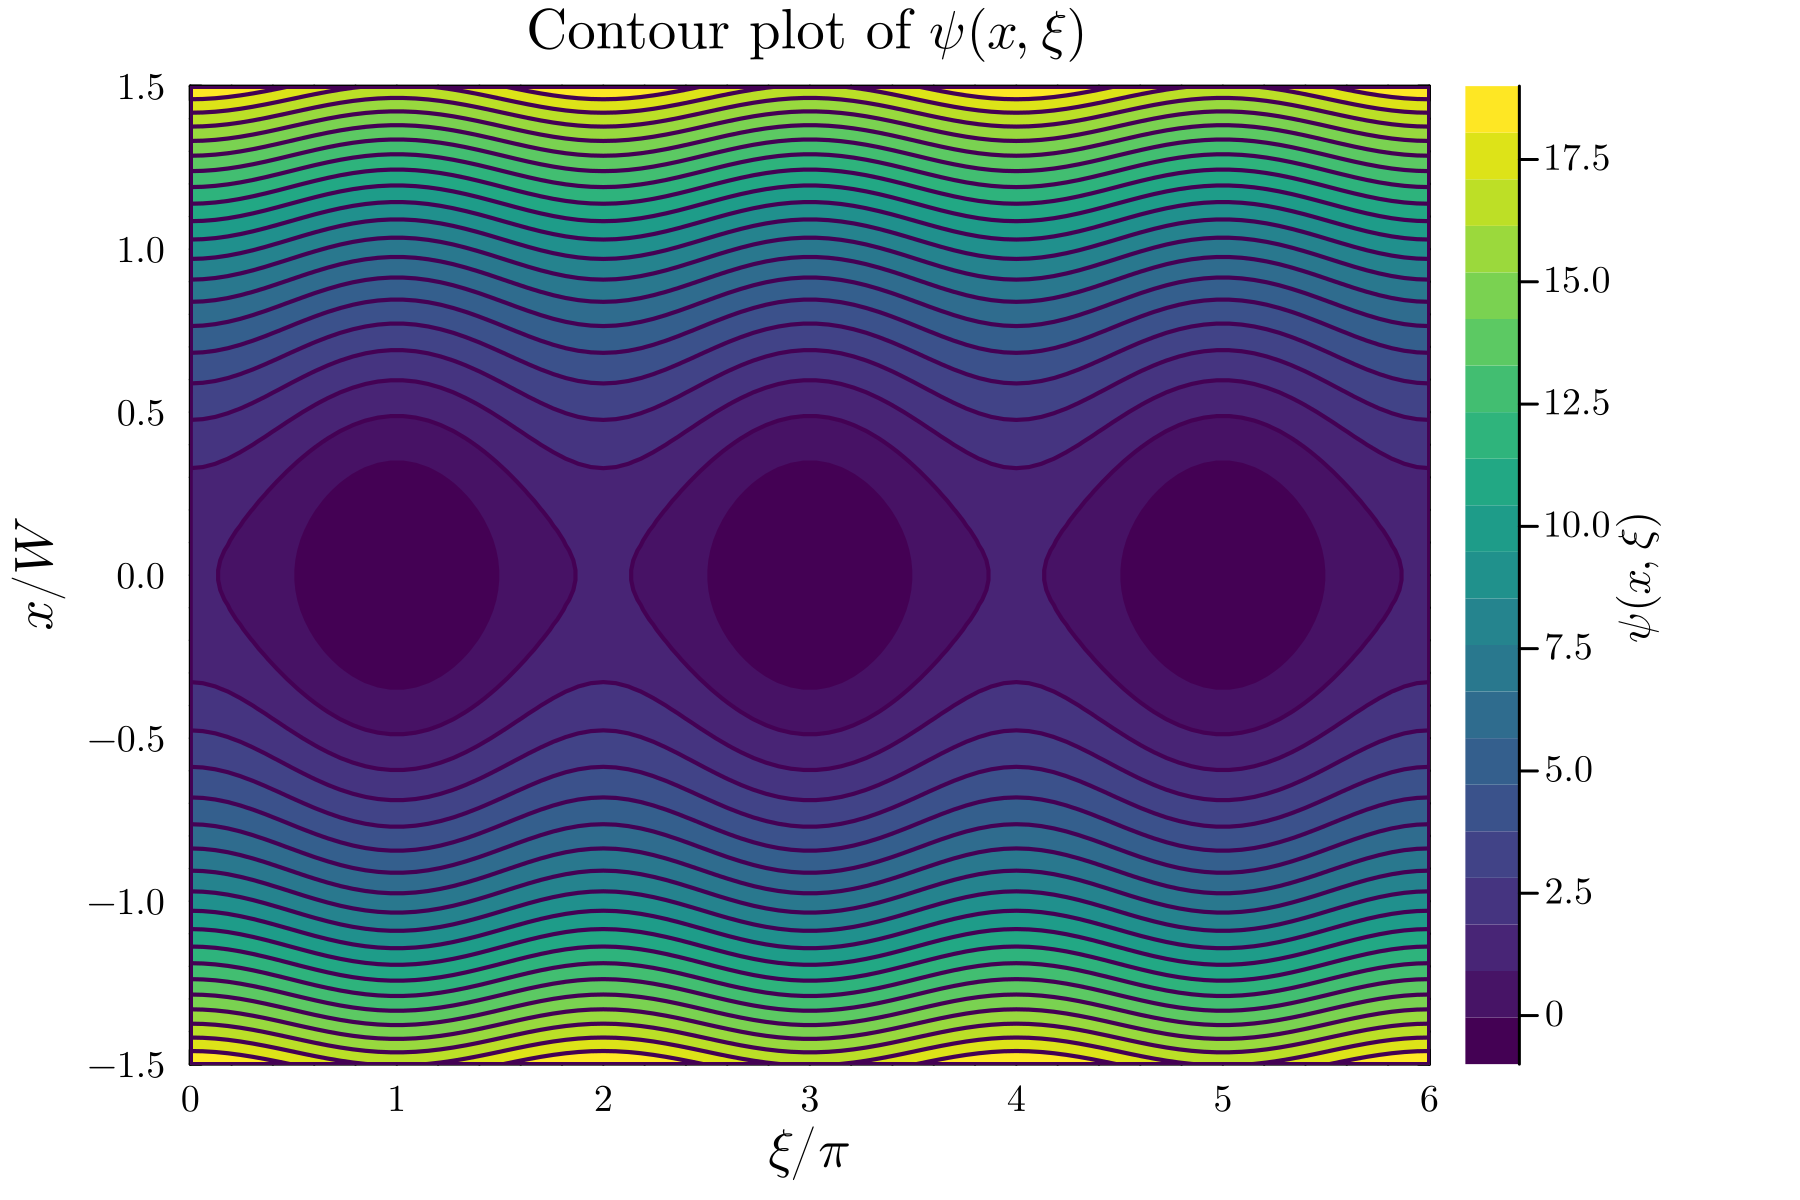

In [8]:
# Parameters
Ψ = 1.0
W = 1.0

# Define the function
ψ(x, ξ) = Ψ * (8*(x/W)^2 + cos(ξ))

# Create coordinate ranges
x = LinRange(-1.5, 1.5, 100)
ξ = LinRange(0, 6π, 100)

# Create grid and evaluate function
x_grid = repeat(x', length(ξ), 1)  # Make x a row vector repeated vertically
ξ_grid = repeat(ξ, 1, length(x))   # Make ξ a column vector repeated horizontally
z = ψ.(x_grid, ξ_grid)             # Element-wise evaluation

# Create contour plot with proper labels
contour(ξ/π, x/W, z',
        ylabel=L"$x/W$",
        xlabel=L"$\xi/ \pi$",
        title=L"Contour plot of $\psi(x, \xi)$",
        color=:viridis,
        fill=true,
        colorbar_title=L"$\psi(x, \xi)$",
        levels=20, 
        dpi = 300,
        right_margin=-10*Plots.mm,
        )
# savefig("psi_contour.png")

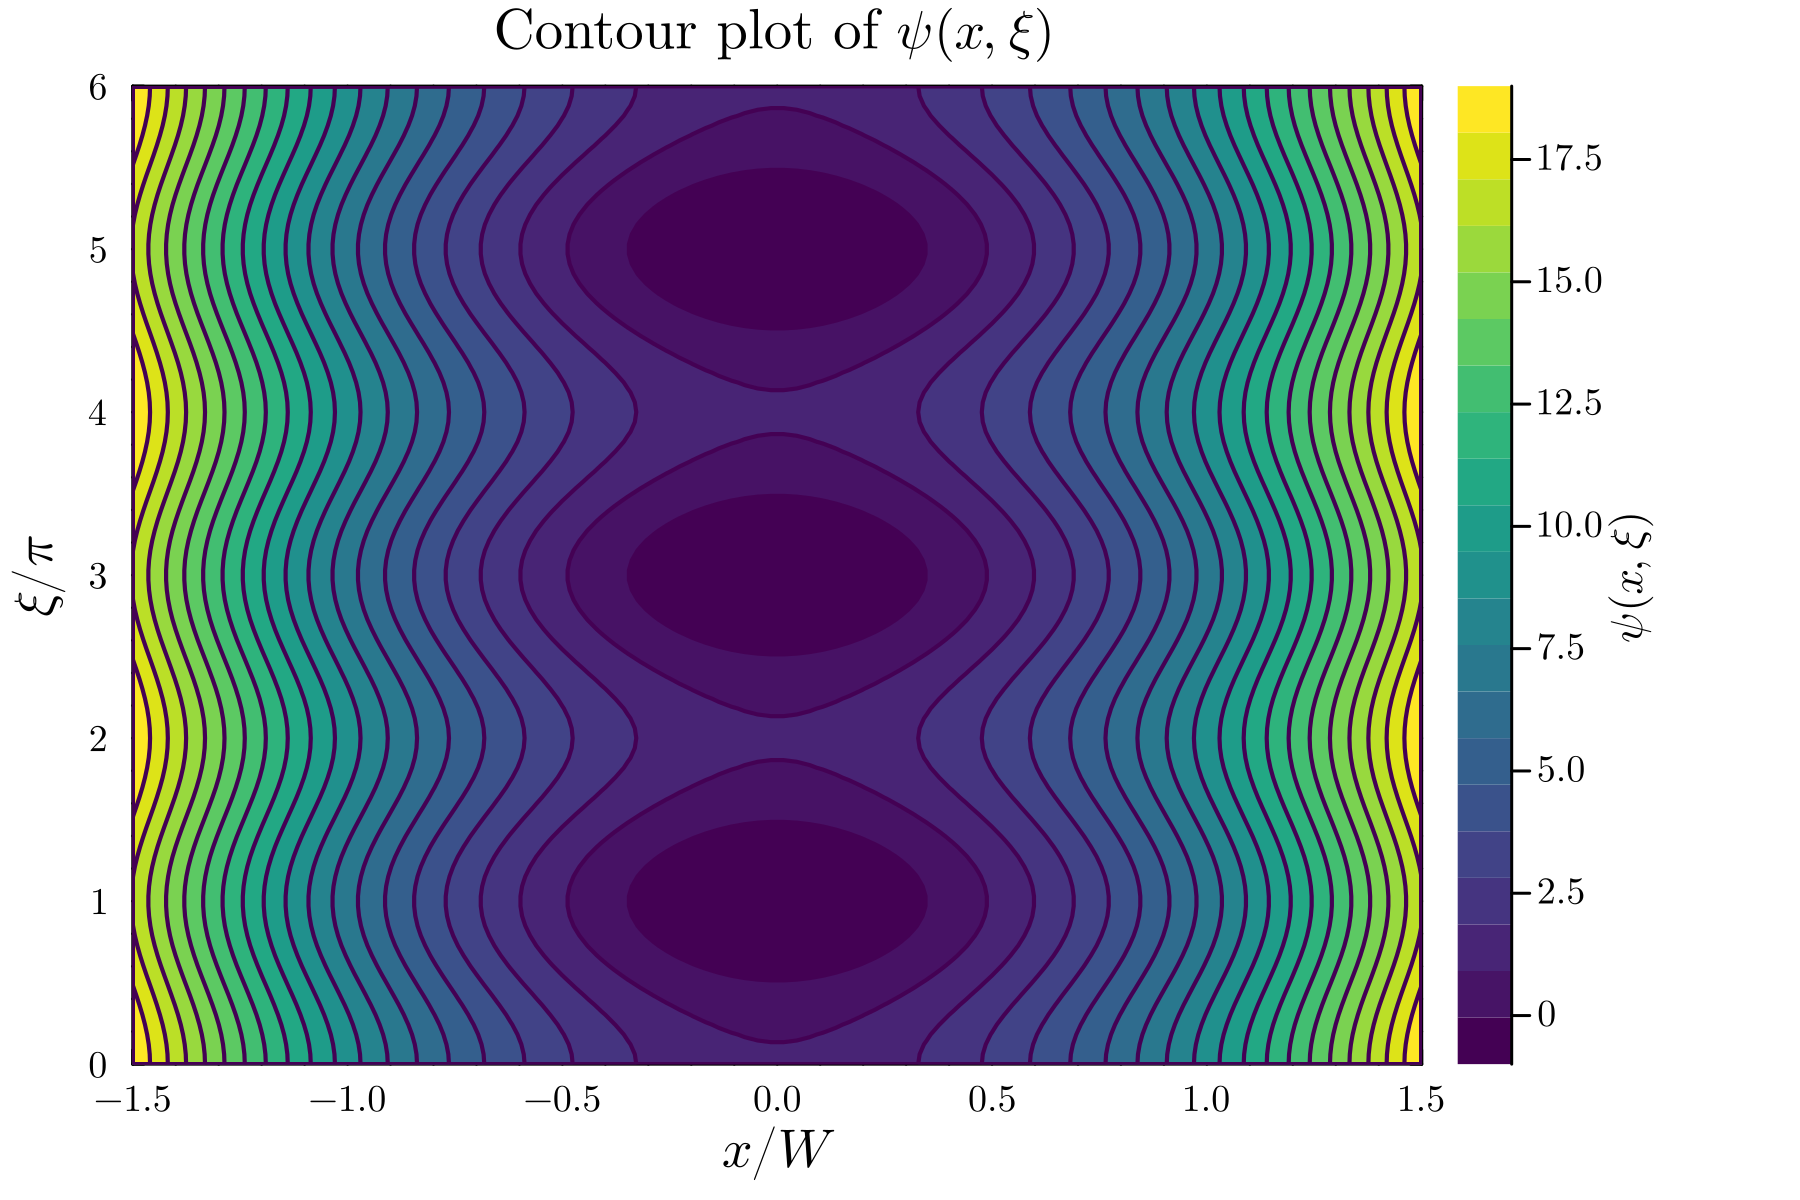

In [9]:
# Create contour plot with proper labels
theme(:dao)
contour(x/W, ξ/π, z,
        xlabel=L"$x/W$",
        ylabel=L"$\xi/ \pi$",
        title=L"Contour plot of $\psi(x, \xi)$",
        color=:viridis,
        fill=true,
        colorbar_title=L"$\psi(x, \xi)$",
        levels=20, 
        dpi = 300,
        right_margin=-15*Plots.mm,
        )
#savefig("psi_contour2.png")

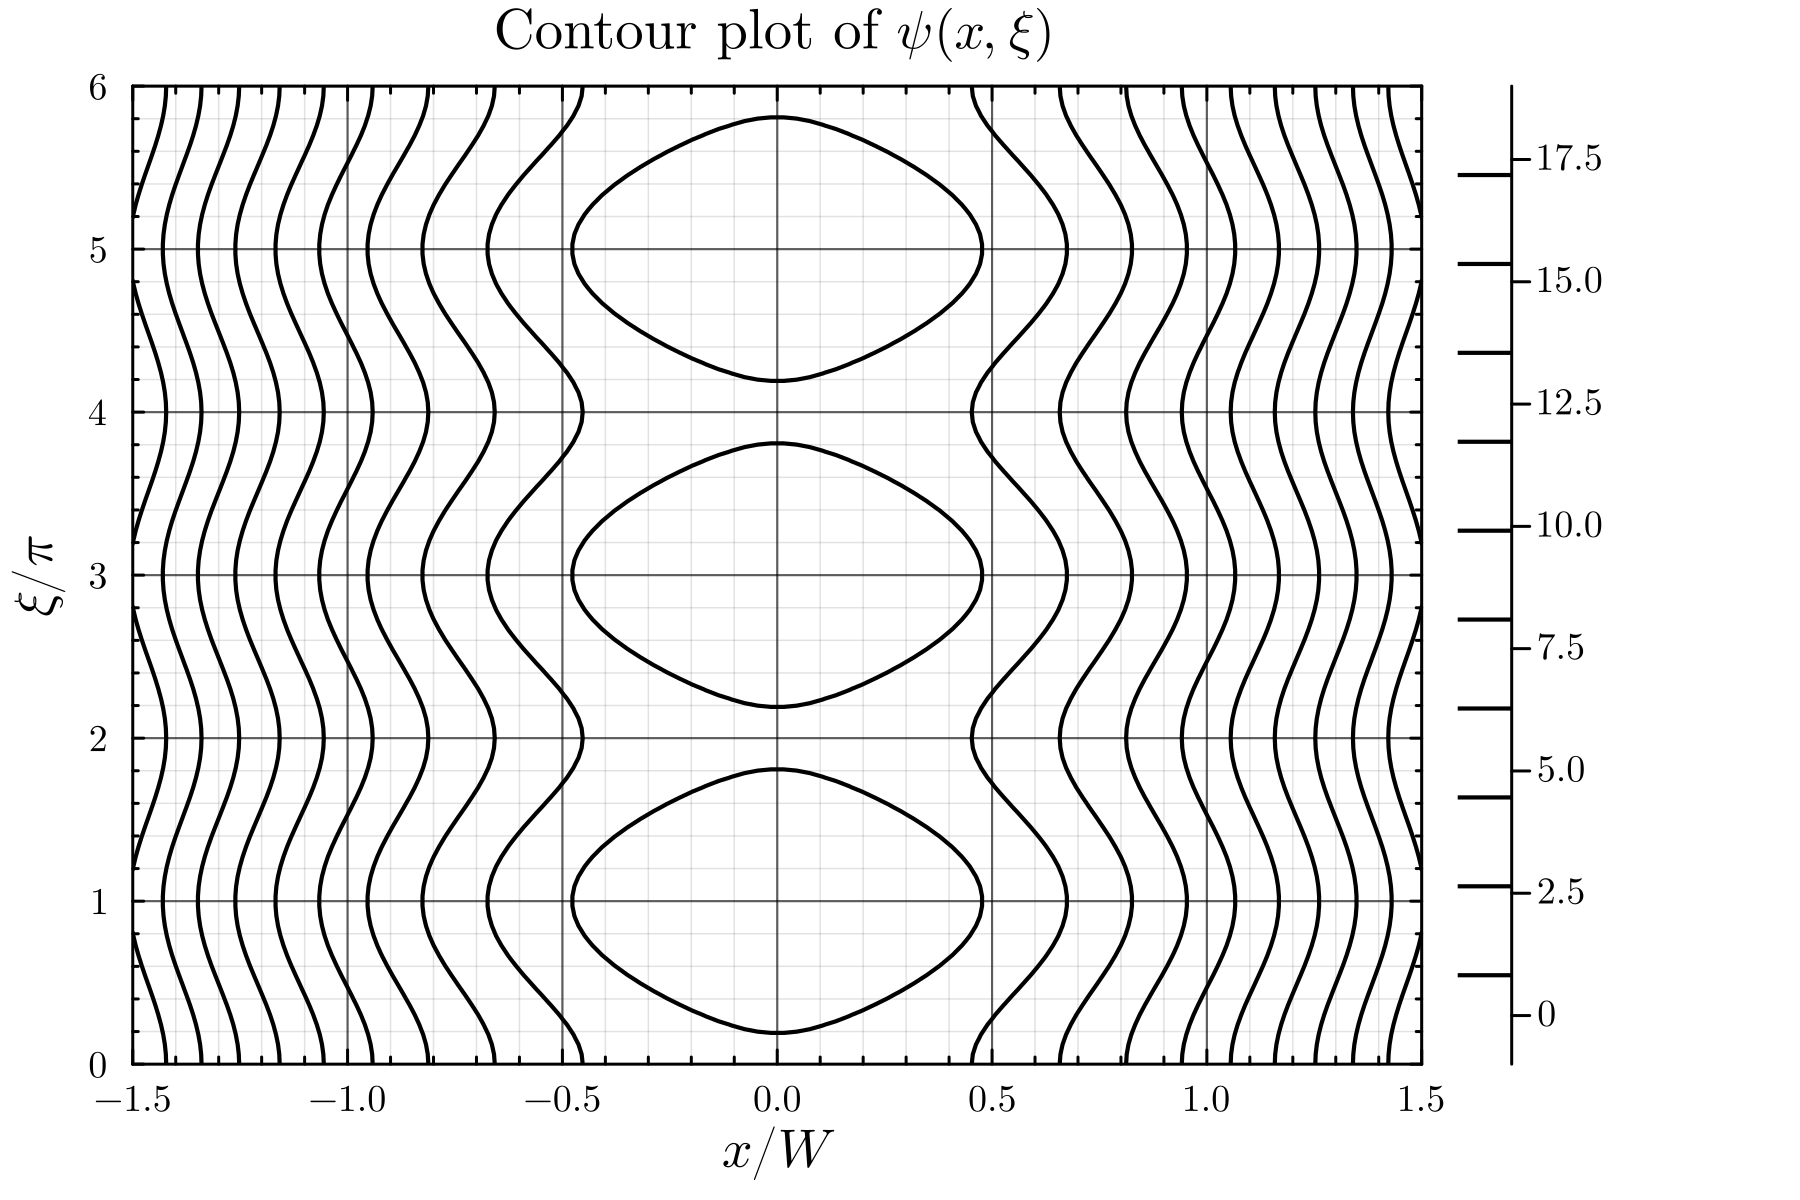

In [10]:
contour(x/W, ξ/π, z,
        xlabel=L"$x/W$",
        ylabel=L"$\xi/ \pi$",
        title=L"Contour plot of $\psi(x, \xi)$",
        color=:black,
        fill=false,
        #colorbar_title=L"$\psi(x, \xi)$",
        levels=10, 
        dpi = 300,
        right_margin=-15*Plots.mm,
        )